In [149]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
from keras import backend as K
from experiment_constant import *
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
[W, B] = pickle.load(open('mnistnet100percenttightness.pkl', 'rb'))

In [151]:
experiment = ConstantExperiment([28 ** 2, 10, 10], 0.123, 0.321, W, B, activation = 'sigmoid')

In [152]:
mean_bound, std_bound = experiment.get_mean_std_error()

In [153]:
inp = np.random.randn(28 ** 2)
errors = experiment.get_error(inp, repetitions = 100000)
mean_exp = np.mean(np.abs(errors))
print(mean_exp / mean_bound)

0.3865857417241777


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


(100, 10000, 10)
(100, 10) (100, 10)


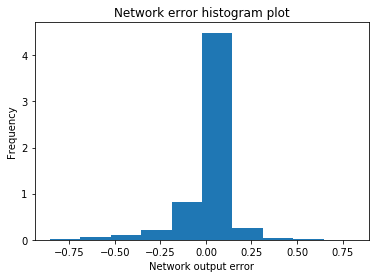

Error; maximal over inputs, average over dropout:
True values array mean: 0.170448 variance 0.238366
Experiment 0.113294 Std 0.259575
Equation   0.151172 Std 0.332359
Tightness  74.9% Std 78.1%


(0.113294005, 0.25957534, 0.15117202591896056, 0.33235928159020817, 0.2383663)

In [228]:
experiment.run(repetitions = 10000, inputs = 100)